## Torch lightning example

In [2]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import random

print("Lightning version:", pl.__version__)

Lightning version: 2.3.1


### Training and testing with torch lightning

In [3]:
# -----------------
# MODEL
# -----------------
class LightningMNISTClassifier(pl.LightningModule):
    """A simple neural network for classifying MNIST digits using PyTorch Lightning."""

    def __init__(self):
        """Initialize the model with three linear layers."""
        super().__init__()
        self.layer_1 = torch.nn.Linear(28 * 28, 128)
        self.layer_2 = torch.nn.Linear(128, 256)
        self.layer_3 = torch.nn.Linear(256, 10)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28).

        Returns:
            torch.Tensor: Log-softmax probabilities for each class.
        """
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)  # Flatten the input tensor
        x = self.layer_1(x)
        x = torch.relu(x)
        x = self.layer_2(x)
        x = torch.relu(x)
        x = self.layer_3(x)
        x = torch.log_softmax(x, dim=1)  # Apply log-softmax activation
        return x

    def cross_entropy_loss(self, logits, labels):
        """
        Compute the cross-entropy loss.

        Args:
            logits (torch.Tensor): Logits from the model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: Cross-entropy loss.
        """
        return torch.nn.functional.cross_entropy(logits, labels)

    def training_step(self, train_batch, batch_idx):
        """
        Training step.

        Args:
            train_batch (tuple): Batch of data and labels.
            batch_idx (int): Batch index.

        Returns:
            torch.Tensor: Training loss.
        """
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        """
        Validation step.

        Args:
            val_batch (tuple): Batch of data and labels.
            batch_idx (int): Batch index.
        """
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        """
        Configure the optimizer.

        Returns:
            torch.optim.Optimizer: Adam optimizer.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [4]:
# ----------------
# DATA
# ----------------
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
mnist_train, mnist_val = random_split(mnist_train, [55000, 5000])  # Split the training data into training and validation sets
train_dataloader = DataLoader(mnist_train, batch_size=64)  # Training data loader
val_loader = DataLoader(mnist_val, batch_size=64)  # Validation data loader
test_loader = DataLoader(mnist_test, batch_size=64)  # Test data loader


In [5]:
# ----------------
# MODEL INITIALIZATION AND TRAINING
# ----------------
model = LightningMNISTClassifier()
trainer = pl.Trainer(
    max_epochs=5,
    log_every_n_steps=100,  # Log metrics every 100 steps
)
trainer.fit(model, train_dataloader, val_loader)  # Train the model

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/fabiocat/miniconda3/envs/pl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /Users/fabiocat/Documents/git/pl/lightning_logs

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | layer_1 | Linear | 100 K  | train
1 | layer_2 | Linear | 33.0 K | train
2 | layer_3 | Linear | 2.6 K  | train
-------------------------------------------
136 K     Trainable param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/fabiocat/miniconda3/envs/pl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/fabiocat/miniconda3/envs/pl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [6]:
# ----------------
# FUNCTION TO DO PREDICTION
# ----------------
def show_random_example(model, dataset):
    """
    Show a random example from the dataset along with its predicted and actual labels.

    Args:
        model (torch.nn.Module): Trained model.
        dataset (torch.utils.data.Dataset): Dataset to sample from.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Get a random index
    idx = random.randint(0, len(dataset) - 1)
    
    # Get the image and label
    img, label = dataset[idx]
    
    # Add batch dimension and perform inference
    with torch.no_grad():
        logits = model(img.unsqueeze(0))  # Add batch dimension
        prediction = torch.argmax(logits, dim=1).item()  # Get predicted label
    
    # Convert image to numpy array for plotting
    img = img.numpy().squeeze()
    
    # Plot the image
    plt.imshow(img, cmap='gray')
    plt.title(f'Actual Label: {label}, Predicted Label: {prediction}')
    plt.show()

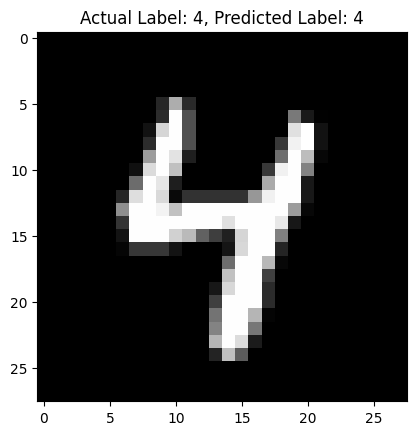

In [7]:
# ----------------
# INFERENCE
# ----------------
# Show a random example from the test set along with its predicted and actual labels
show_random_example(model, mnist_test)